Goal: build an encoder-deconder network that can reproduce a 2D radar line just based on XY coordinates

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy import signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import IPython

from tensorflow import keras
from tensorflow.keras import layers, initializers, Model
from tensorflow.keras.callbacks import LearningRateScheduler

2025-01-30 05:39:48.160990: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 05:39:48.203147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 05:39:48.203204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 05:39:48.204427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 05:39:48.212074: I tensorflow/core/platform/cpu_feature_guar

In [2]:
"""
Prepare the dataset
"""

data_path = './data/1308201000.sgy'

## Grab the X and Y coordinate data from the file for each
## radar frame. Coordinates will be used as the training features.
x_coords = []
y_coords = []

with segyio.open(data_path, ignore_geometry=True) as segyfile:
    
    for i in range(len(segyfile.trace)):
        curr_x = segyfile.header[i][segyio.TraceField.GroupX]
        curr_y = segyfile.header[i][segyio.TraceField.GroupY]
        
        x_coords.append(curr_x)
        y_coords.append(curr_y)
        
    seis_line = segyio.tools.collect(segyfile.trace[:,2100:3000])
    
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
coord_data = np.vstack((x_coords, y_coords)).T


## SCALE THE COORDINATE INPUT FEATURES
coord_scaler = StandardScaler()
seis_scaler = StandardScaler()

X = coord_scaler.fit_transform(coord_data)
Y = seis_scaler.fit_transform(seis_line)


## USE SOME VALIDATION DATA
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.005, random_state=150)

## OR USE ALL DATA
# X_train, Y_train = X, Y

In [3]:
"""
Create the First ML Model
"""

###############
## Define the input layer
input_layer = keras.Input(shape=(X_train.shape[1],), name='input')

###############    
## Set initialization   
k_init = initializers.RandomNormal(seed=10)  # choose initializer for dense layers

##~~~~~~~~~~~~~~~~~
## NEURAL NETWORK 
##~~~~~~~~~~~~~~~~~

x = layers.Dense(4, kernel_initializer=k_init)(input_layer)
x = layers.Activation('relu')(x)
x = layers.BatchNormalization()(x)

nodes = [4, 8, 8, 16, 16, 32, 32, 64, 64,
         128, 128, 128, 128, 256, 256, 256, 256,
         512, 512, 512, 512, 1024, 1024, 1024, 1024]

for node in nodes:
    x = layers.Dense(node, kernel_initializer=k_init)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)

###############    
## Output layer
out = layers.Dense(seis_line.shape[1], activation='linear', 
                   kernel_initializer=k_init, name='output')(x)

###############
## Compile the model

model = Model(inputs=input_layer, outputs=out)
model.compile(loss='mse', optimizer='Adam')

## Print model summary
print(model.summary())

2025-01-30 05:39:52.572822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43505 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:3d:00.0, compute capability: 8.9
2025-01-30 05:39:52.574233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43505 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:99:00.0, compute capability: 8.9


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                             

7/7 [==============================] - 0s 25ms/step - loss: 0.4724 - val_loss: 0.6925 - lr: 3.0518e-08
Model Train Time: 8.79 minutes


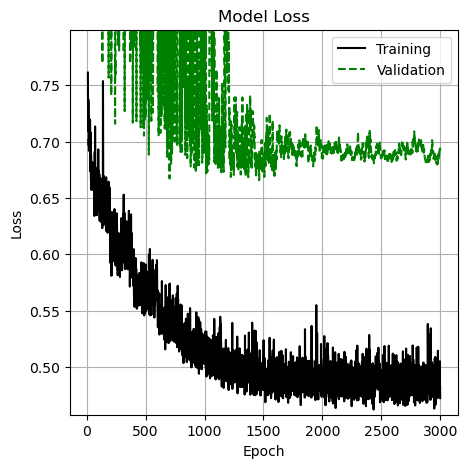

In [4]:
"""
Train the First Model
"""

BATCH_SIZE = 64
EPOCHS = 3000

## Callback to keep the output text clean
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_epoch_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
        
## Learning rate schedule
def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 200.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

        
callbacks = [ClearTrainingOutput(), lrate]
# callbacks = [ClearTrainingOutput()]

## Start timer to track model train time
start = time.time()


## Kick off the training
try:
    history = model.fit(X_train, Y_train, 
                    validation_data = (x_test, y_test),
                    epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks = callbacks)
except NameError:   # catching case where validation data not defined
    history = model.fit(X_train, Y_train, 
                    epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks = callbacks)

## Capture model train completion time
end = time.time()
print("Model Train Time: {} minutes".format(round((end-start)/60, 2)))


##--------------------------
## Loss Plot

loss = history.history['loss']
try:
    val_loss = history.history['val_loss']
except KeyError:
    pass

xc = range(EPOCHS)

plot_epoch_start = 10
plot_max = np.amax(loss[plot_epoch_start:]) + (0.05*np.amax(loss[plot_epoch_start:]))
plot_min = np.amin(loss[plot_epoch_start:]) - (0.01*np.amin(loss[plot_epoch_start:]))

plt.figure(figsize=(5,5))
plt.title('Model Loss')
plt.plot(xc[plot_epoch_start:], loss[plot_epoch_start:], color='black', label='Training')
try:
    plt.plot(xc[plot_epoch_start:], val_loss[plot_epoch_start:], color='green', linestyle='--', label='Validation')
except KeyError:
    pass
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid('both')
plt.ylim(plot_min, plot_max)
plt.show()

14/14 [==============================] - 0s 3ms/step


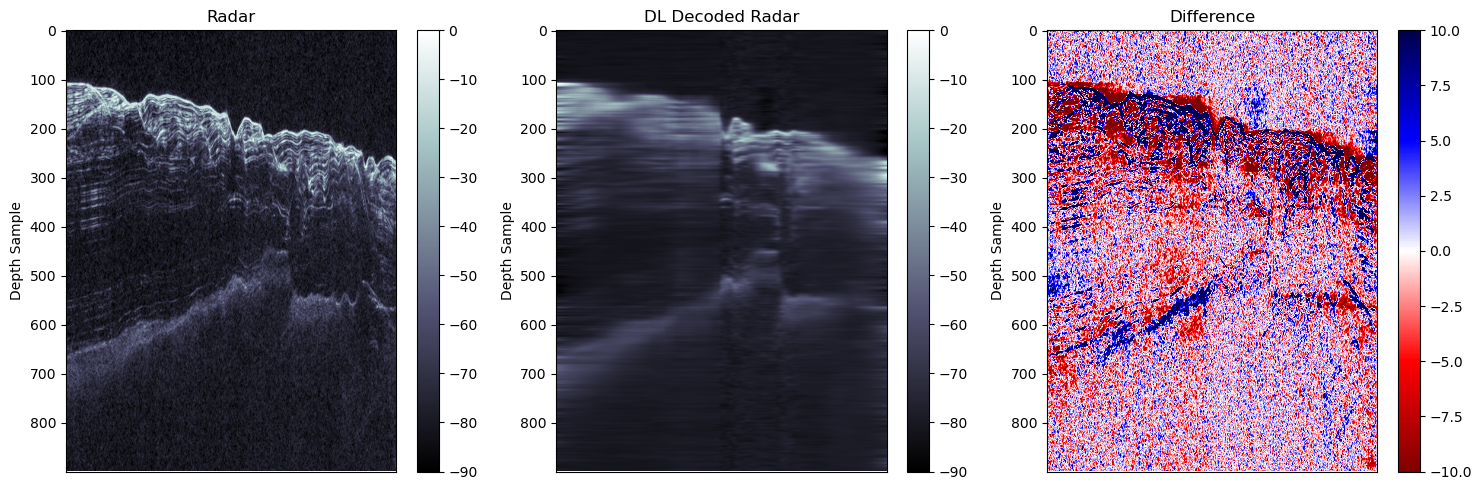

In [5]:
"""
Visualize prediction after first model
"""

## Initialize the predictions array
prediction = model.predict(X)
prediction = np.squeeze(seis_scaler.inverse_transform(prediction))
predictions = np.copy(prediction)

## Allow model to train for 50 epochs 50 times, final prediction
## will be an average of these predictions
avg_iters = 50
for i in range(avg_iters):
    print("Running {}/{} iteration".format(i+1, avg_iters))
    model.fit(X_train, Y_train, epochs = 50, batch_size=BATCH_SIZE, 
              verbose=1, callbacks = callbacks)
    prediction = model.predict(X)
    prediction = np.squeeze(seis_scaler.inverse_transform(prediction))
    predictions = np.dstack((predictions, prediction))

prediction = np.mean(predictions, axis=-1)
difference = seis_line - prediction

####################
## Plot the prediction
color_min = -90
color_max = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

seis_plot = ax[0].imshow(seis_line.T, cmap='bone', aspect='auto', vmax=color_max, vmin=color_min)
dl_plot = ax[1].imshow(prediction.T, cmap='bone', aspect='auto', vmax=color_max, vmin=color_min)
diff_plot = ax[2].imshow(difference.T, cmap='seismic_r', aspect='auto', vmax=10, vmin=-10)

ax[0].set_title('Radar')
ax[1].set_title('DL Decoded Radar')
ax[2].set_title('Difference')

ax[0].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax[2].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)

ax[0].set_ylabel('Depth Sample')
ax[1].set_ylabel('Depth Sample')
ax[2].set_ylabel('Depth Sample')

plt.colorbar(seis_plot, ax=ax[0])
plt.colorbar(dl_plot, ax=ax[1])
plt.colorbar(diff_plot, ax=ax[2])

plt.tight_layout()
# plt.show()
plt.savefig("./images/model1_prediction.jpg")

In [6]:
"""
Create the Second ML Model
"""

## Data prep
## Use the prediction from the first model as the input feature
X_train_auto = seis_scaler.transform(prediction)
Y_train_auto = np.copy(Y)

###############
## Define the input layer
input_layer = keras.Input(shape=(X_train_auto.shape[1],), name='input')


###############
## Hidden layers

x = layers.Dense(1024)(input_layer)
x = layers.Activation('relu')(x)
x = layers.BatchNormalization()(x)

nodes = [512, 256, 256, 128, 256, 512]

for node in nodes:
    x = layers.Dense(node)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)

###############    
## Output layer
out = layers.Dense(X_train_auto.shape[1], activation='linear', name='output')(x)

###############
## Compile the model
model_auto = Model(inputs=input_layer, outputs=out)
model_auto.compile(loss='mse', optimizer='Adam')

print(model_auto.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 900)]             0         
                                                                 
 dense_26 (Dense)            (None, 1024)              922624    
                                                                 
 activation_26 (Activation)  (None, 1024)              0         
                                                                 
 batch_normalization_26 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 activation_27 (Activation)  (None, 512)               0         
                                                           

7/7 [==============================] - 0s 7ms/step - loss: 0.0769 - lr: 9.5367e-10
Model Train Time: 7.58 minutes


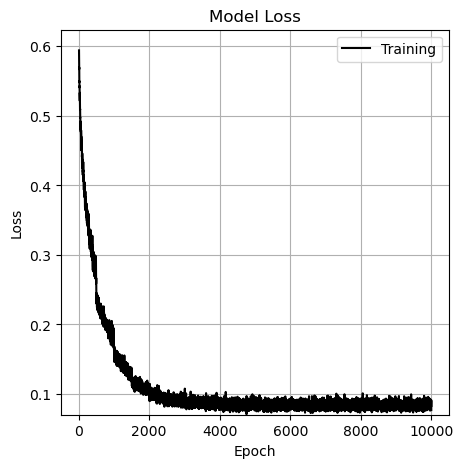

In [7]:
"""
Train the Second Model
"""

BATCH_SIZE = 64
EPOCHS = 10000

## Callback to keep the output text clean
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_epoch_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
        
## Learning rate schedule
def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 500.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

        
callbacks = [ClearTrainingOutput(), lrate]
# callbacks = [ClearTrainingOutput()]

## Start timer to track train time
start = time.time()

## Kick of training
try:
    history_auto = model_auto.fit(X_train_auto, Y_train_auto, 
                    validation_data = (x_test_auto, y_test_auto),
                    epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks = callbacks)

except NameError:   # catching case where validation data not defined
    history_auto = model_auto.fit(X_train_auto, Y_train_auto, 
                    epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks = callbacks)

## Capture train time
end = time.time()
print("Model Train Time: {} minutes".format(round((end-start)/60, 2)))


##--------------------------
## Loss Plot

loss = history_auto.history['loss']
try:
    val_loss = history_auto.history['val_loss']
except:
    pass

xc = range(EPOCHS)

plot_epoch_start = 10
plot_max = np.amax(loss[plot_epoch_start:]) + (0.05*np.amax(loss[plot_epoch_start:]))
plot_min = np.amin(loss[plot_epoch_start:]) - (0.01*np.amin(loss[plot_epoch_start:]))

plt.figure(figsize=(5,5))
plt.title('Model Loss')
plt.plot(xc[plot_epoch_start:], loss[plot_epoch_start:], color='black', label='Training')
try:
    plt.plot(xc[plot_epoch_start:], val_loss[plot_epoch_start:], color='green', linestyle='--', label='Validation')
except:
    pass
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid('both')
plt.ylim(plot_min, plot_max)
plt.show()

14/14 [==============================] - 0s 1ms/step


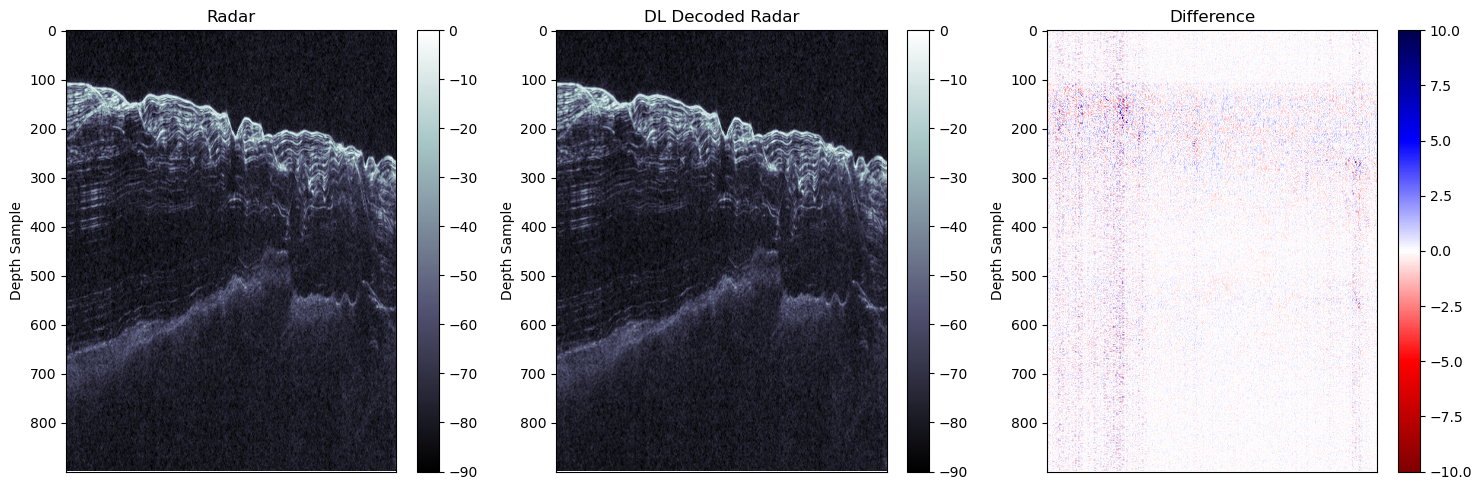

In [11]:
"""
Capture prediction accuracy after second model
"""

## Initialize prediction
prediction_auto = model_auto.predict(X_train_auto)
prediction_auto = np.squeeze(seis_scaler.inverse_transform(prediction_auto))
predictions_auto = np.copy(prediction_auto)

## Allow model to train for 50 epochs 50 times, final prediction
## will be an average of these predictions
avg_iters = 50
for i in range(avg_iters):
    print("Running {}/{} iteration".format(i+1, avg_iters))
    model_auto.fit(X_train_auto, Y_train_auto, epochs = 50, batch_size=BATCH_SIZE, verbose=1, callbacks = callbacks)
    prediction_auto = model_auto.predict(X_train_auto)
    prediction_auto = np.squeeze(seis_scaler.inverse_transform(prediction_auto))
    predictions_auto = np.dstack((predictions_auto, prediction_auto))

prediction_auto = np.mean(predictions_auto, axis=-1)
difference_auto = seis_line - prediction_auto

####################
## Plot the prediction
color_min = -90
color_max = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

seis_plot = ax[0].imshow(seis_line.T, cmap='bone', aspect='auto', vmax=color_max, vmin=color_min)
dl_plot = ax[1].imshow(prediction_auto.T, cmap='bone', aspect='auto', vmax=color_max, vmin=color_min)
diff_plot = ax[2].imshow(difference_auto.T, cmap='seismic_r', aspect='auto', vmax=10, vmin=-10)

ax[0].set_title('Radar')
ax[1].set_title('DL Decoded Radar')
ax[2].set_title('Difference')

plt.colorbar(seis_plot, ax=ax[0])
plt.colorbar(dl_plot, ax=ax[1])
plt.colorbar(diff_plot, ax=ax[2])

ax[0].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax[2].tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)

ax[0].set_ylabel('Depth Sample')
ax[1].set_ylabel('Depth Sample')
ax[2].set_ylabel('Depth Sample')

plt.tight_layout()
# plt.show()
plt.savefig("./images/model2_prediction.jpg")

In [9]:
"""
Compute the root mean squared error to
evaluate model accuracy
"""

rmse = []
for i in range(seis_line.shape[0]):
    tmp_seis = seis_line[i,:]
    tmp_pred = prediction_auto[i,:]
    
    rmse.append(np.sqrt((tmp_pred - tmp_seis)**2).mean())
    
avg_rmse = round(np.mean(rmse), 2)
print("Average RMSE: {}".format(avg_rmse))

Average RMSE: 0.9300000071525574


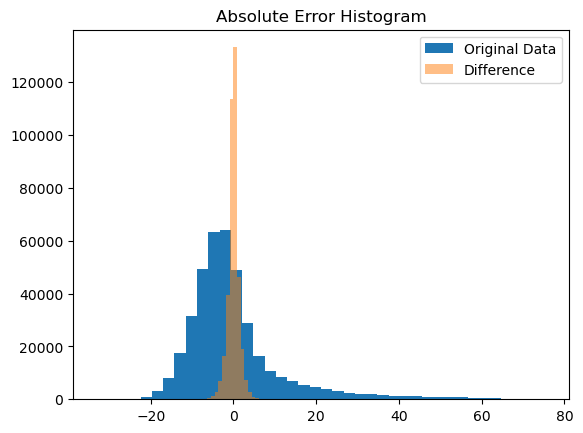

In [10]:
"""
Visualize the magnitude of model error versus
the data range
"""

detrend_seis = np.zeros(seis_line.shape)

for i in range(seis_line.shape[0]):
    detrend_seis[i,:] = signal.detrend(seis_line[i,:])
    
plt.figure()
plt.title("Absolute Error Histogram")
plt.hist(detrend_seis.flatten(), bins=40, label="Original Data")
plt.hist(difference_auto.flatten(), bins=40, alpha=0.5, label="Difference")
plt.legend()
plt.show()